In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
# from tabulate import tabulate

import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from seasonal_analysis import * 

from sklearn.metrics import mean_squared_error as mse

import matplotlib
matplotlib.rc_file_defaults()
%matplotlib inline

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print(f"device: {device}")

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


### Import data

In [2]:
# Parameters
start="1980-01-01"
end="2015-12-31"

# TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"
# TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

TRAIN_PATH = '../../data/norris/enriched_obs/enriched_combined_obs_norris.pkl'

In [3]:
# st = create_station_dataframe(TRAIN_PATH, start, end, add_yesterday=True, basin_filter = None, filter_incomplete_years = True)

data = DataPreprocessing(train_path=TRAIN_PATH, start=start, end=end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = 'station')

In [4]:
data.st

,Date,Prec,Station,X,Y,Z,year,CWV_norris,RH2_norris,RH500_norris,T2_norris,T2max_norris,T2min_norris,Td2_norris,precip_norris,rain_norris,u10_norris,u500_norris,v10_norris,v500_norris,Region,month,season,obs_yesterday
5250,2010-04-02,3.7,Deosai,75.540,35.090,3910.0,2010,3.900692,67.949028,77.829865,267.663208,273.243530,260.863953,261.393494,4.494797,-9.685755e-07,2.888071,11.761724,4.219371,8.389020,WestUIB,4,AM,0.0
5251,2010-04-03,3.8,Deosai,75.540,35.090,3910.0,2010,4.840403,86.734413,88.465652,267.096832,271.658447,261.891418,264.979767,9.052742,-2.729893e-05,2.912471,17.005379,3.910732,11.143065,WestUIB,4,AM,3.7
5252,2010-04-04,3.9,Deosai,75.540,35.090,3910.0,2010,4.417695,87.843475,81.684746,266.134796,271.721741,260.397675,264.265442,8.247139,-1.713634e-07,3.589097,19.146626,3.896772,12.554890,WestUIB,4,AM,3.8
5253,2010-04-05,2.1,Deosai,75.540,35.090,3910.0,2010,3.710116,79.812820,76.067314,264.495697,272.745667,258.341980,260.719025,2.020142,0.000000e+00,0.689556,13.286465,1.232544,7.707052,WestUIB,4,AM,3.9
5254,2010-04-06,0.0,Deosai,75.540,35.090,3910.0,2010,2.205372,52.509171,22.733532,265.309937,272.083191,257.120880,256.406616,0.000000,0.000000e+00,-3.163874,6.187045,-0.202066,0.232556,WestUIB,4,AM,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362453,2002-03-27,0.0,Kaza,-181865.387,1025749.843,3639.0,2002,0.915667,16.914795,19.830414,265.655151,270.611908,261.328156,244.228470,0.000000,0.000000e+00,-0.326931,2.077137,-0.203771,-1.107406,EastUIB,3,JFM,0.0
362454,2002-03-28,0.0,Kaza,-181865.387,1025749.843,3639.0,2002,0.736175,14.063007,14.571829,266.203613,271.294678,260.577942,241.997269,0.000000,0.000000e+00,0.265043,-0.162587,-0.171392,-0.366935,EastUIB,3,JFM,0.0
362455,2002-03-29,0.0,Kaza,-181865.387,1025749.843,3639.0,2002,1.371173,17.868814,25.336786,267.185150,271.854889,262.180695,246.129974,0.000000,0.000000e+00,0.157151,1.934790,-0.386113,-1.764641,EastUIB,3,JFM,0.0
362456,2002-03-30,0.0,Kaza,-181865.387,1025749.843,3639.0,2002,2.904233,30.141476,45.924198,270.359222,275.374878,264.183624,254.144836,0.000000,0.000000e+00,-0.320685,5.337810,0.078967,-2.275732,EastUIB,3,JFM,0.0


260055


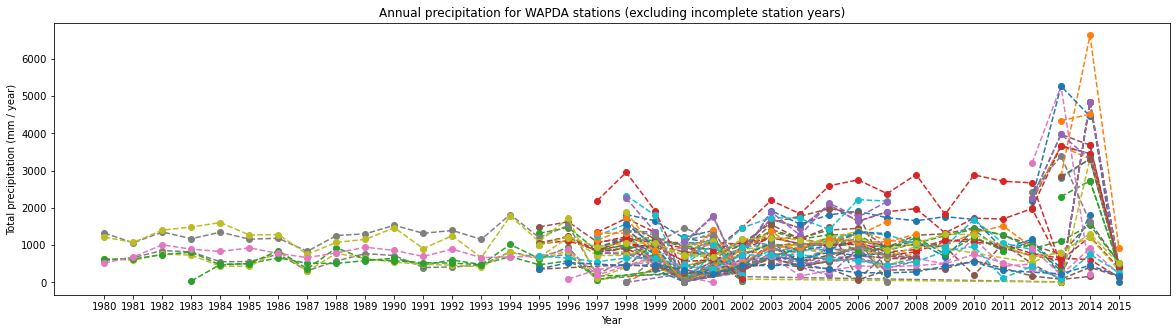

In [5]:
print(len(data.st))
df = data.st.groupby(["Station","year"]).sum()['precip_norris'].reset_index()
plt.figure(figsize=(20,5))
for s in df.Station.unique():
    df_s = df[df["Station"]==s].reset_index()[['year','precip_norris']].sort_values('year')
    x = df_s['year']
    y = df_s['precip_norris']
    plt.plot(x,y,'--o',label=s)
# plt.legend()
plt.ylabel('Total precipitation (mm / year)')
plt.xlabel('Year')
plt.xticks(sorted(df.year.unique()))
plt.title('Annual precipitation for WAPDA stations (excluding incomplete station years)')
plt.show()

In [6]:
data.split_stations()

In [7]:
# data.st.rename(columns={'Longitude':'X','Latitude':'Y','Elevation':'Z'}, inplace=True)
# data.st.rename(columns={'Lon':'X','Lat':'Y'}, inplace=True)

In [8]:
data.st['doy'] = data.st['Date'].dt.dayofyear

In [9]:
data.st['doy_sin'] = data.st['doy'].transform(lambda x: np.sin(x))
data.st['doy_cos'] = data.st['doy'].transform(lambda x: np.cos(x))

In [10]:
# data.st.Prec = data.st.Prec.astype('float64')
data.st.Prec.dtype

dtype('float64')

In [11]:
data.st.season.unique()

array(['AM', 'JJAS', 'OND', 'JFM'], dtype=object)

In [12]:
# def rename_seasons(df : pd.DataFrame, dict_names = {'Premonsoon (AM)' : 'AM', 'Monsoon (JJAS)' : 'JJAS', 'Postmonsoon (OND)' : 'OND', 'Winter (JFM)' : 'JMF'}):
#     for k,v in dict_names.items():
#         df[df['season']== k] = v
#     return df

### Split data into held out sets for K-fold cross validation

### Prepare data

In [13]:
predictors = [
                'wrf_prcp',
                'wrf_prcp_-2','wrf_prcp_-1','wrf_prcp_1','wrf_prcp_2',
                'Z',
                #'doy',
                'doy_sin',
                'doy_cos',
                'X',
                'Y',
                'aspect',
                'slope',
                'year',
                'era5_u','era5_u_-1','era5_u_-2','era5_u_1','era5_u_2',
                'era5_v','era5_v_-1','era5_v_-2','era5_v_1','era5_v_2',
             ]

# doy = ['doy_sin', 'doy_cos']
# dem = ['Z','slope','aspect']
# xy = ['X','Y']
# year = ['year']
# cwv = ['CWV_norris']
# rh = ['RH2_norris', 'RH500_norris']
# temp = ['T2_norris', 'T2max_norris', 'T2min_norris', 'Td2_norris']
# prec = ['precip_norris', 'rain_norris']
# wind = ['u10_norris', 'u500_norris', 'v10_norris', 'v500_norris']

predictors = [ 
                'doy_sin',
                'doy_cos',
                'Z',
                'X',
                'Y',
                #'aspect',
                #'slope',
                'year',
                'CWV_norris', 
                'RH2_norris', 'RH500_norris', 
                'T2_norris', 'T2max_norris', 'T2min_norris', 'Td2_norris', 
                'precip_norris', 'rain_norris', 
                'u10_norris', 'u500_norris', 'v10_norris', 'v500_norris',
              ]

# predictors.append('obs_yesterday')

predictand = ['Prec']

data.input_data(predictors, predictand, sort_by_quantile=False)

## Multi-Run: Train model with different hyperparameters

### Model run

In [14]:
params = OrderedDict(
    lr = [0.005]
    ,batch_size = [64]
    ,likelihood_fn = ['bgmm'] #, 'b2gmm'] #['bernoulli_loggaussian','gamma']
    ,hidden_channels = [[50,50]] #[[10], [50], [100], [50,50], [100,100]] #[[10],[30],[50],[100],[10,10],[30,30],[50,50],[100,100]]
    ,dropout_rate = [0]
    ,linear_model = [False] #[False, True]
    #,k = [0]
    ,k = list(range(2)) #list(range(10))
)

epochs = 5

n = 1 
for k,v in params.items():
    n = len(v) * n
print('# models:', n)
print('# epochs:', n*epochs)

# models: 2
# epochs: 10


In [15]:
st_test, predictions = multirun(data, predictors, params, epochs, split_by='station',
                                sequential_samples=False, use_device='cuda')

,run,epoch,loss,valid_loss,test_loss,decision_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,dropout_rate,linear_model,k
0,1,1,1.199274,1.101366,1.324154,1.101366,15.449237,15.492588,0.005,64,bgmm,"[50, 50]",0,False,0
1,1,2,1.181277,1.106711,1.321195,1.106711,14.488861,30.057829,0.005,64,bgmm,"[50, 50]",0,False,0
2,1,3,1.175741,1.105954,1.318955,1.105954,15.803683,45.920273,0.005,64,bgmm,"[50, 50]",0,False,0
3,1,4,1.173641,1.106749,1.320946,1.106749,15.481951,61.448987,0.005,64,bgmm,"[50, 50]",0,False,0
4,1,5,1.169977,1.120426,1.330169,1.120426,14.840503,76.365467,0.005,64,bgmm,"[50, 50]",0,False,0
5,2,1,1.222161,1.146441,1.128132,1.146441,16.516637,16.520431,0.005,64,bgmm,"[50, 50]",0,False,1
6,2,2,1.203486,1.190100,1.127721,1.190100,15.481275,32.166268,0.005,64,bgmm,"[50, 50]",0,False,1
7,2,3,1.197968,1.148224,1.148969,1.148224,15.724638,47.992295,0.005,64,bgmm,"[50, 50]",0,False,1
8,2,4,1.195440,1.146644,1.145270,1.146644,17.098020,65.150516,0.005,64,bgmm,"[50, 50]",0,False,1
9,2,5,1.192764,1.167781,1.130224,1.167781,16.874911,82.084472,0.005,64,bgmm,"[50, 50]",0,False,1


In [16]:
# network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))

In [17]:
for run in predictions.keys():
    for i in range(len(params['k'])):
        predictions[run][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[run]['k_all'] = predictions[run][f'k{i}']
        else:
            predictions[run]['k_all'] = pd.concat([predictions[run]['k_all'],predictions[run][f'k{i}']])

In [18]:
# Table of predictions
# seasons = ['Winter (JFM)', 'Premonsoon (AM)', 'Monsoon (JJAS)','Postmonsoon (OND)']
seasons = ['JFM', 'AM', 'JJAS','OND']
# table_of_predictions(predictions, seasons, sample_cols=['sample'])

In [19]:
# for key in predictions.keys():
#     predictions[key]['k_all'].rename(columns={"sample": "sample_0"}, inplace=True)

In [20]:
# predictions['bgmm_[50]_False']['k_all'].rename(columns={"wrf_prcp": "bannister_wrf_prcp", "precip_norris": "wrf_prcp"}, inplace=True)

In [21]:
n_samples = 10
sample_cols = [f'sample_{i}' for i in range(n_samples)]
add_cols = []

columns = ['Prec','wrf_prcp','wrf_bc_prcp','precip_norris'] #+ sample_cols + add_cols

In [22]:
for p in predictions.keys(): 
    for k,v in predictions[p].items():
        v['wrf_prcp'] = v['precip_norris'] 
        v['wrf_bc_prcp'] = v['precip_norris'] 

In [23]:
predictions.keys()

dict_keys(['bgmm_[50, 50]_NL_B=64_D=0'])

In [24]:
for k,v in predictions.items():
    print(k, ':\t', v['k_all'].BS.mean())

bgmm_[50, 50]_NL_B=64_D=0 :	 0.5686743683926266


In [25]:
for k,v in predictions.items():
    print(k, ':\t', v['k_all'].QS.mean())

bgmm_[50, 50]_NL_B=64_D=0 :	 1.3672600457874629


In [26]:
# for k,v in predictions.items():
#     rename_seasons(v['k_all'])

In [27]:
table_of_predictions_ks_test(predictions, seasons, columns, sample_cols, add_cols)

ValueError: Data passed to ks_2samp must not be empty

In [28]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'smape', prefix='smape')

Model                      JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
-------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Bann                       0.30        0.25          0.41       0.40         0.35         0.34           0.44        0.39
BannCorr                   0.30        0.25          0.41       0.40         0.35         0.34           0.44        0.39
Norr                       0.30        0.25          0.41       0.40         0.35         0.34           0.44        0.39
bgmm_[50, 50]_NL_B=64_D=0  0.23        0.20          0.27       0.23         0.19         0.13           0.36        0.30


In [29]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'edd', prefix='edd')

Model                      JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
-------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Bann                       12.31       10.00         12.11      11.00        36.33        37.00          7.46        6.00
BannCorr                   12.31       10.00         12.11      11.00        36.33        37.00          7.46        6.00
Norr                       12.31       10.00         12.11      11.00        36.33        37.00          7.46        6.00
bgmm_[50, 50]_NL_B=64_D=0  7.25        4.50          5.71       4.40         10.59        7.30           4.73        3.15


In [30]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'ae', prefix='ae')

Model                      JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
-------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Bann                       116.08      84.44         87.04      59.29        462.64       275.54         58.62       30.62
BannCorr                   116.08      84.44         87.04      59.29        462.64       275.54         58.62       30.62
Norr                       116.08      84.44         87.04      59.29        462.64       275.54         58.62       30.62
bgmm_[50, 50]_NL_B=64_D=0  79.93       63.16         64.47      42.84        186.07       138.52         50.46       32.55


In [31]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'se', prefix='se')

Model                      JFM mean      JFM median    AM mean       AM median    JJAS mean        JJAS median    OND mean      OND median
-------------------------  ------------  ------------  ------------  -----------  ---------------  -------------  ------------  ------------
Bann                       25618.21      7130.11       13451.88      3516.50      443145.37        75922.82       8621.89       937.48
BannCorr                   25618.21      7130.11       13451.88      3516.50      443145.37        75922.82       8621.89       937.48
Norr                       25618.21      7130.11       13451.88      3516.50      443145.37        75922.82       8621.89       937.48
bgmm_[50, 50]_NL_B=64_D=0  527467688.12  51735724.66   414936192.51  10283370.10  127490884404.04  1645475141.43  719325573.39  3796214.82


In [ ]:
a = pd.read_csv('results.csv')

b = a.groupby(['k','run']).agg({'valid_loss': 'min', 
                                 'hidden_channels': 'first', 
                                 'likelihood_fn': 'first',
                                 'lr':'first',
                                 'batch_size':'first',
                                 'dropout_rate':'first',
                                 'linear_model':'first'})

c = b.groupby(['run']).agg({'valid_loss': 'mean', 
                        'hidden_channels': 'first', 
                        'likelihood_fn': 'first',
                        'lr':'first',
                        'batch_size':'first',
                        'dropout_rate':'first',
                         'linear_model':'first'}
                   ).sort_values('valid_loss').reset_index()

d = c.groupby(['hidden_channels',
           'likelihood_fn',
           'lr',
           'batch_size',
           'dropout_rate',
           'linear_model']).agg({'valid_loss': 'mean'}
                   ).sort_values('valid_loss').reset_index()

In [ ]:
d

In [ ]:
c